# Importing Libraries:

In [55]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
from sklearn.metrics import roc_curve, auc, log_loss, confusion_matrix,f1_score
from sklearn.naive_bayes import MultinomialNB 
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV

# Reading Data:

In [2]:
data = pd.read_csv('training_variants')

In [3]:
print(data.shape)
data.head(4)

(3321, 4)


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3


In [4]:
# Text data
data2 = pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [5]:
print(data2.shape)
data2.head(4)

(3321, 2)


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...


# Data Cleaning:

In [6]:
# Checking null values for [Gene]:

idx = data['Gene'].isnull().values.any()
if idx == False:
    print('There are NO null values')
else:
    print('There are some null values')

There are NO null values


In [7]:
# Checking null values for [Variation]:

idx = data['Variation'].isnull().values.any()
if idx == False:
    print('There are NO null values')
else:
    print('There are some null values')

There are NO null values


In [8]:
# Checking null values for [TEXT]:

idx = data2['TEXT'].isnull().values.any()
if idx == False:
    print('There are NO null values')
else:
    print('There are SOME null values')

There are SOME null values


In [9]:
idx1 = data2[data2.isna().any(axis=1)]
print('The following are the NaN values for TEXT:')
idx1

The following are the NaN values for TEXT:


,ID,TEXT
1109,1109,NaN
1277,1277,NaN
1407,1407,NaN
1639,1639,NaN
2755,2755,NaN


- since there are only 5 points with NaN values, we could drop these ID's. But, we already have small dataset so we have to find a workaround these nan values instead of throwing them.

In [10]:
# Merging the two datasets on ID:

data_ = pd.merge(data, data2,on='ID', how='left')
data_.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [11]:
# Workaround for nan values of [TEXT]: We add the [Gene] type and [Variation] name in the [TEXT] column

data_.loc[data_['TEXT'].isnull(),'TEXT'] = data_['Gene'] +' '+data_['Variation']

In [12]:
# Checking if our workaround has worked or not:

idx3 = data.isnull().values.any()
if idx3 == False:
    print('There are NO null values in the dataset.')
else:
    print('There are SOME null values')

There are NO null values in the dataset.


In [13]:
# Cleaning the [TEXT]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

def clean(text):
    '''
    This function gets rid of all punctuation marks, special characters, stop words
    and returns cleaned words 
    
    '''
    sent = text.lower().strip() 
    sent = re.sub('[^a-zA-Z]',' ',text) # replacing any character other than letters from (a-z and A-Z) with empty space
    sent = sent.split() 
    final = [word for word in sent if not word in set(stop_words)] # returning the words which are not in the stopwords set
    final_sent =  ' '.join(final) # Combining the words to form the texts
    return final_sent

v = data_.TEXT.values
text = [] # this list contains cleaned texts
for z in tqdm(range(len(v))): # this loop applies the function (clean) to every data point
    r1 = clean((v[z]))
    text.append(r1)

[nltk_data] Downloading package stopwords to C:\Users\PANCHAYAT
[nltk_data]     SAMITI 01\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


100%|██████████████████████████████████████████████████████████████████████████████| 3321/3321 [01:44<00:00, 31.77it/s]


In [14]:
# Adding the cleaned TEXT in the dataset:
data_['TEXT'] = text

In [22]:
# Defining the dependent and independent variables:

x = data_.drop(['Class'],axis = 1)
y = data_['Class']

# Data Visualisation:

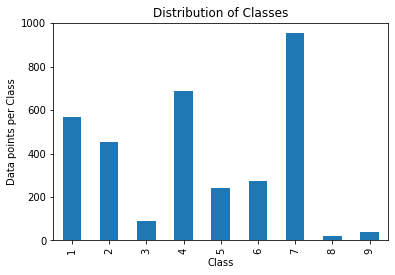

Number of data points in class 7 : 953 ( 28.696 %)
Number of data points in class 4 : 686 ( 20.656 %)
Number of data points in class 1 : 568 ( 17.103 %)
Number of data points in class 2 : 452 ( 13.61 %)
Number of data points in class 6 : 275 ( 8.281 %)
Number of data points in class 5 : 242 ( 7.287 %)
Number of data points in class 3 : 89 ( 2.68 %)
Number of data points in class 9 : 37 ( 1.114 %)
Number of data points in class 8 : 19 ( 0.572 %)


In [16]:
class_distribution = data['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of Classes')
plt.show()
print('='*100)

sorted_class = np.argsort(-class_distribution.values) # this returns the indices of classes which are sorted in descending order of their occurence
for i in sorted_class:
    print('Number of data points in class', i+1, ':',class_distribution.values[i], '(', np.round((class_distribution.values[i]/data.shape[0]*100), 3), '%)')

- we see that this is an imbalanced dataset. 
- To counter this problem we will be setting the parameter (class_weights = 'balanced') in the SGD Classifier

# Gene:

In [17]:
genes = data['Gene'].value_counts() # to check the different types of Genes present
genes1 = len(np.unique(np.array(data["Gene"]))) # to check the unique Genes present
print('The number of unique Genes in the dataset are:',genes1)
genes.head(7)

The number of unique Genes in the dataset are: 264


BRCA1    264
TP53     163
EGFR     141
PTEN     126
BRCA2    125
KIT       99
BRAF      93
Name: Gene, dtype: int64

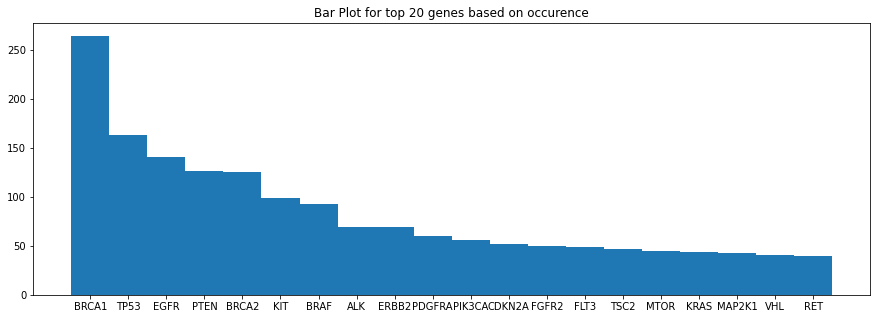

In [18]:
# Bar plot for top 20 genes based on the number of occurence:

thisdict = (dict(genes))
gene = [] # this list contains all the genes
for x in thisdict.keys():
    gene.append(x)

count = [] # # this list contains the counts of genes present
for y in thisdict.values():
    count.append(y)

plt.figure(figsize=(15, 5))
x_axis = gene[:20]
y_axis = count[:20]
plt.bar(x_axis,y_axis,width = 1)
plt.title('Bar Plot for top 20 genes based on occurence')
plt.show()

# Variation:

In [19]:
variation = data['Variation'].value_counts()
variation1 = len(np.unique(np.array(data["Variation"])))
print('The number of unique Variations in the dataset are:',variation1)
variation

The number of unique Variations in the dataset are: 2996


Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
                        ..
K341A                    1
S170N                    1
M1293A                   1
I1766S                   1
Y236D                    1
Name: Variation, Length: 2996, dtype: int64

# Confusion matrix, Precision,Recall:

In [20]:
def conufsion_precision_recall(y_actual, y_predict):
    '''
    This function plots the confusion matrix, recall & precision
    
    '''
    C = confusion_matrix(y_actual, y_predict)     
    
    precision =(C/C.sum(axis=0)) # dividing each element of the confusion matrix with the sum of elements in that specific column
    # By doing the above operation we ensure that the sum of column elements = 1
    
    recall =(((C.T)/(C.sum(axis=1))).T) # dividing each element of the confusion matrix with the sum of elements in that row
    # Here, we ensure that the sum of row elements = 1
    
    labels = [1,2,3,4,5,6,7,8,9] # since we have 9 classes

    # Confusion Matrix
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    print('='*125)
    
    # Precision Matrix
    plt.figure(figsize=(20,5))
    sns.heatmap(precision, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title('Precision Matrix')
    plt.show()
    print('='*125)
    
    # Recall Matrix
    plt.figure(figsize=(20,5))
    sns.heatmap(recall, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title('Recall Matrix')
    plt.show()

# Splitting the Data:

In [24]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,stratify = y,random_state = 0)

x_trnew,x_cv,y_trnew,y_cv = train_test_split(x_train,y_train,test_size = 0.2,stratify = y_train,random_state = 0)

# stratify makes sure that the distribution of class labels is similar in train-cv-test datasets

In [25]:
# Printing the shape of all the datasets we have

print('Original train data shape',x_train.shape)
print('='*100)
print('Original test data shape',x_test.shape)
print('='*100)
print('New train shape',x_trnew.shape)
print('='*100)
print('CV shape',x_cv.shape)
print('='*100)

Original train data shape (2656, 4)
Original test data shape (665, 4)
New train shape (2124, 4)
CV shape (532, 4)


# Data Preprocessing: 

# One Hot Encoding:

In [26]:
# One Hot Encoding on Gene

ONE = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

# Reshaping the features so that we get n-rows & just 1 column (n = number of rows in particular dataset)
gene_train_orig = ONE.fit_transform(x_train['Gene'].values.reshape(-1,1)) # fitting on only the train data
gene_test_orig = ONE.transform(x_test['Gene'].values.reshape(-1,1)) # Applying the transformation on other datasets
gene_train_new = ONE.transform(x_trnew['Gene'].values.reshape(-1,1))
gene_ohe_cv = ONE.transform(x_cv['Gene'].values.reshape(-1,1))

print('Original train data shape',gene_train_orig.shape)
print('='*100)
print('Original test data shape',gene_test_orig.shape)
print('='*100)

Original train data shape (2656, 247)
Original test data shape (665, 247)


In [27]:
# One Hot Encoding on Variation:

variation_train_orig = ONE.fit_transform(x_train['Variation'].values.reshape(-1,1))
variation_test_orig = ONE.transform(x_test['Variation'].values.reshape(-1,1))
variation_train_new = ONE.transform(x_trnew['Variation'].values.reshape(-1,1))
variation_ohe_cv = ONE.transform(x_cv['Variation'].values.reshape(-1,1))

print('Original train data shape',variation_train_orig.shape)
print('='*100)
print('Original test data shape',variation_test_orig.shape)
print('='*100)

Original train data shape (2656, 2410)
Original test data shape (665, 2410)


In [28]:
# TF-IDF on TEXT:

# Using unigran,bigram & trigram and limiting the number of features obtained to 1000
# Also, only those words are considered to form tf-idf values which appear for more than or equal to 10 times (min_df =10)
tfidf = TfidfVectorizer(min_df=10,ngram_range=(1,3), max_features=1000)

text_train_orignal = tfidf.fit_transform(x_train['TEXT'].values)
text_test_orignal = tfidf.transform(x_test['TEXT'].values)
text_train_new = tfidf.transform(x_trnew['TEXT'].values)
text_cv = tfidf.transform(x_cv['TEXT'].values)

print('After TF-IDF')
print('Original train data shape',text_train_orignal.shape)
print('='*100)
print('Original test data shape',text_test_orignal.shape)

After TF-IDF
Original train data shape (2656, 1000)
Original test data shape (665, 1000)


# Concatenating the features:

In [29]:
# Stacking the features horizontally:

X_train = hstack((gene_train_orig,variation_train_orig,text_train_orignal)).tocsr()
X_test = hstack((gene_test_orig,variation_test_orig,text_test_orignal)).tocsr()
X_trn = hstack((gene_train_new,variation_train_new,text_train_new)).tocsr()
X_cv = hstack((gene_ohe_cv,variation_ohe_cv,text_cv)).tocsr()
print("="*100)
print("Final Data matrix")
print('Train data shape:',X_train.shape, y_train.shape)
print('Test data shape:',X_test.shape, y_test.shape)
print('CV data shape:',X_cv.shape, y_cv.shape)
print("="*100)

Final Data matrix
Train data shape: (2656, 3657) (2656,)
Test data shape: (665, 3657) (665,)
CV data shape: (532, 3657) (532,)


# Models:

# Random Model

In [30]:
from numpy.random import default_rng
rng = default_rng()

test_points = X_test.shape[0] # this is our number of rows in test dataset
y_pred = np.zeros((test_points,9)) # creating a 2d array to store the random probability values of 9 classes
for i in range(test_points):
    y_pred[i] = rng.dirichlet(np.ones(9),size=1) # this line returns 9 random values between 0-1 such that their sum = 1
print("Log loss on Test Data using Random Model",log_loss(y_test,y_pred, eps=1e-15))

Log loss on Test Data using Random Model 2.659027223346562


- Random model has a log loss of (2.7355) So,now we have a sort of yardstick to compare our following models with.

# Logistic Regression:

In [31]:
alpha = [10**-3,10**-2,0.1,1,5,10,50] # hyperparameter for SGD classifier.

log_error_array=[] # this list contains the log-loss obtained with different values of alpha
for i in (alpha):
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', class_weight = 'balanced', random_state=0) #balancing the class_labels
    clf.fit(X_trn, y_trnew)                                                                           #(class_weight = 'balanced') 
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid") # to get predictions in form of probabilities to use log_loss as a metric
    sig_clf.fit(X_trn, y_trnew)
    predict_y = sig_clf.predict_proba(X_cv) 
    
    log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_)) # adding the log-loss for different values of alpha
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))


best_alpha = np.argmin(log_error_array) # selecting the alpha with minimum log_loss
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log',class_weight = 'balanced', random_state=0)
clf.fit(X_train, y_train) # now fitting on entire train data with best aplha value
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_ytrain = sig_clf.predict_proba(X_train) # getting log_loss on train set, to check overfitting
print('*'*100)
print('The best alpha value = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_ytrain, labels=clf.classes_))
predict_ytest = sig_clf.predict_proba(X_test)
print('*'*100)
print('The best alpha value = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_ytest, labels=clf.classes_))

For values of alpha =  0.001 The log loss is: 1.0547056918445998
For values of alpha =  0.01 The log loss is: 1.2158116267822936
For values of alpha =  0.1 The log loss is: 1.4806953006028991
For values of alpha =  1 The log loss is: 1.584267361505226
For values of alpha =  5 The log loss is: 1.5967039921979684
For values of alpha =  10 The log loss is: 1.5983543392068418
For values of alpha =  50 The log loss is: 1.5997669950577655
****************************************************************************************************
The best alpha value =  0.001 The train log loss is: 0.7643523170400105
****************************************************************************************************
The best alpha value =  0.001 The test log loss is: 1.0198157927158609


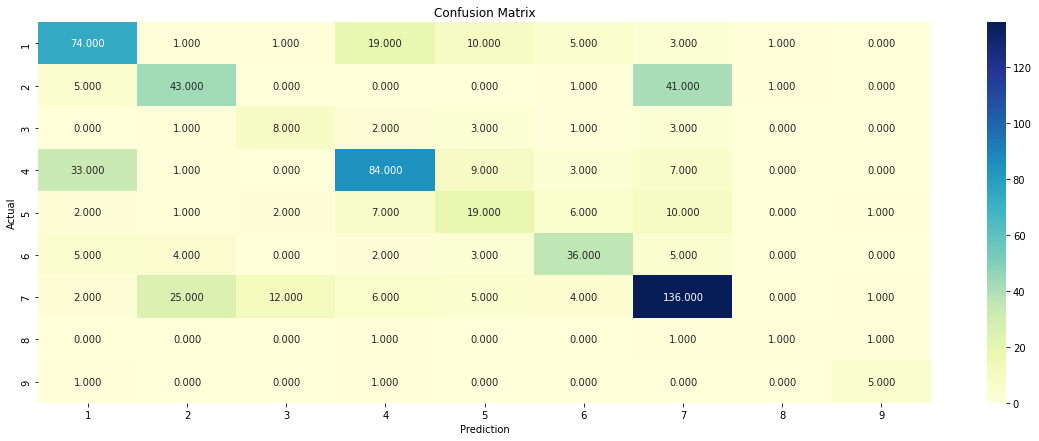

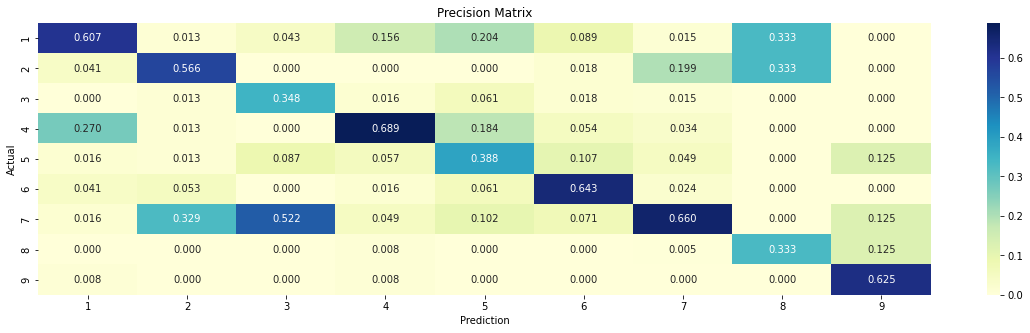

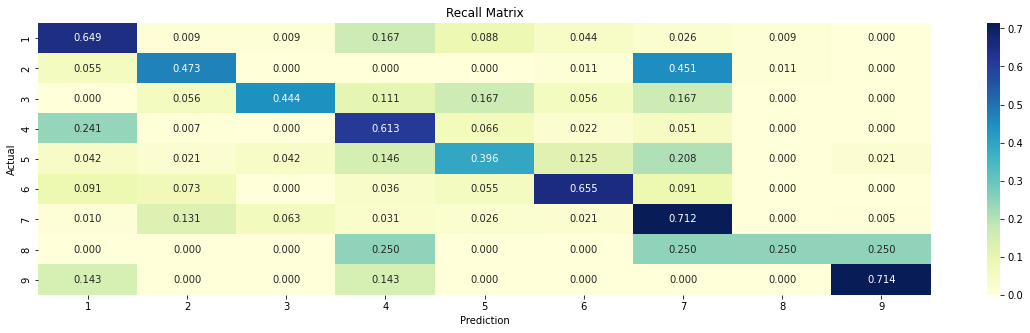

In [32]:
# Confusion matrix for Logistic Regression:  
np.seterr(invalid='ignore')
y_pred_lr = clf.predict(X_test) # predicting on Test Dataset
x1 = conufsion_precision_recall(y_test,y_pred_lr)
x1

- Precision tells us: Of all the points that we predict as belonging to a particular class, how many of them actually belong to that class.
- Example: Consider (Class 7): Our model correctly predicts only 66% of points that actually belong to (Class 7)
- Our aim is to get the 66% as close as to 100% (1.0)

- Recall tells us: Of all the points that actually belong to a class how many have we predicted to be belonging to that same true class
- Example: Consider (Class 7) which is the ground truth. Now (71.2%) of the time our model predicts that the given point belongs to (Class 7),(3.1)% of the time that it belongs to (Class 4), (13.1%) of the time that it belongs to (Class 2) and so on...
- Our aim is to get the 71.2% as close as to 100%. So that 100% of the time our model is correct(But this is an ideal situation)

# Random Forest: Hyperparameter tuning

In [33]:
# Defining the parameters to give to RandomizedSearchCV for coming up with best hyperparameters
#trees = [5,8,10,15,20,25,30,50,100] # high value of this and our model tends to "overfit"
#depth = [2,6,8,10,20] # high value of this and our model tends to "overfit"
#min_sample = [2,5,7,9,15] # high value of this and our model tends to "underfit"
#gain = ['entropy','gini'] 

#parameters = {'n_estimators':trees,'max_depth':depth,'min_samples_split':min_sample,'criterion':gain}

#rf = RandomForestClassifier()
#random_search = RandomizedSearchCV(estimator = rf, param_distributions = parameters, cv = 10)
#random_search.fit(X_train, y_train)

#print(random_search.best_params_)
#print(random_search.best_score_)

- Adjusting the hyperparameters obtained from RandomizedsearchCV we use the following, for avoiding overfitting:
- (n_estimators= 25, min_samples_split= 5, max_depth=5, criterion = 'entropy'

# Fitting model on best hyperparameters:

In [34]:
rf_best = RandomForestClassifier(n_estimators= 25, min_samples_split= 5, max_depth=5, criterion = 'entropy', random_state = 0)
rf_best.fit(X_train,y_train)
sig_clf_rf = CalibratedClassifierCV(rf_best, method="sigmoid") # getting prediction in form of probabilities
sig_clf_rf.fit(X_train, y_train)

rf_train_predict = sig_clf_rf.predict_proba(X_train) # predicting on both train & test set to check overfitting
rf_test_predict = sig_clf_rf.predict_proba(X_test)

print("The train log loss is:",log_loss(y_train, rf_train_predict, labels=clf.classes_))
print("The test log loss is:",log_loss(y_test, rf_test_predict, labels=clf.classes_))

The train log loss is: 0.9430474322861186
The test log loss is: 1.1022622954581842


# Confusion Matrix for Random Forest 

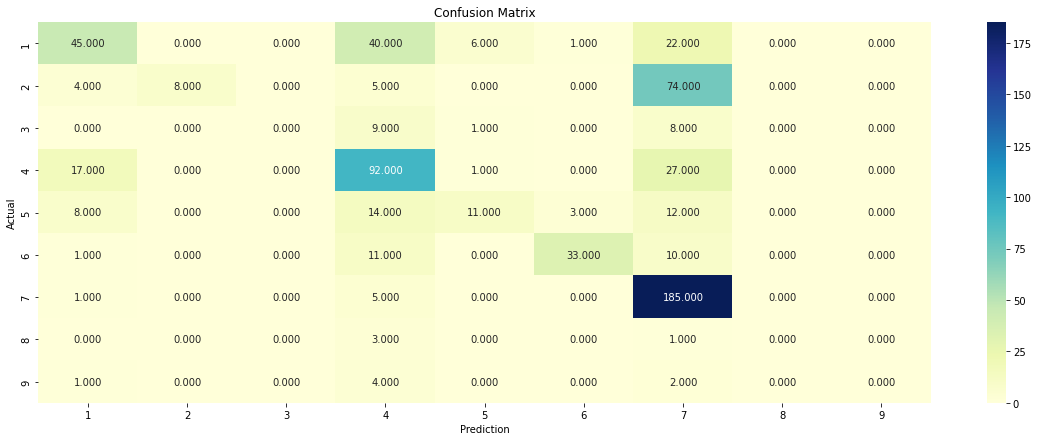

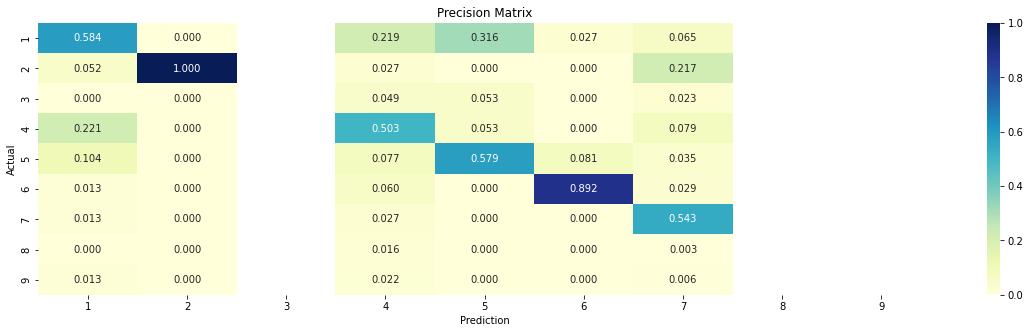

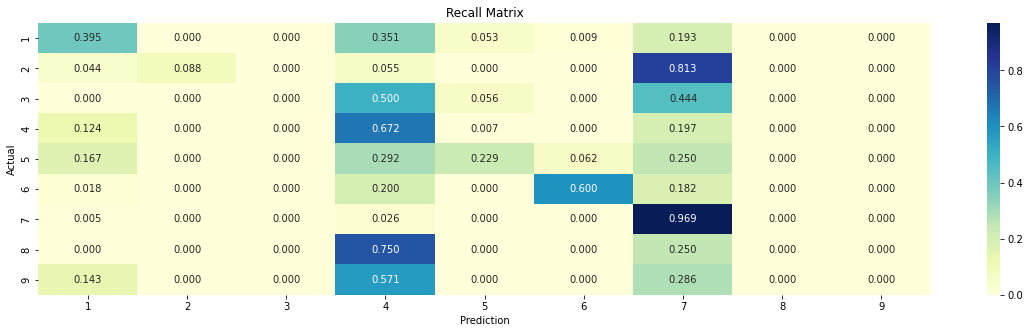

In [35]:
# Confusion matrix for Logistic Regression:
y_pred_rf = rf_best.predict(X_test)
x2 = conufsion_precision_recall(y_test,y_pred_rf)
x2

- Our Random Forest Model, gives (0.0832) higher value of Log loss than Logistic Regression. This approximate same performance is maybe because of high dimensionality(3657), as Random Forest generally performs well when the dimensionality is low.

# Interpretability of model:

In [74]:
i = random.randint(0,len(y_test)) # randomly generate an index from the test dataset
actual = y_test.values[i] # actual class
prob = sig_clf.predict_proba(X_test[i]) # this gives the probability values for 9 classes
predict = np.argmax(prob) + 1 
print('Actual Class:',actual)
print('*'*100)
print('Probability values to interpret:',prob)
print('*'*100)
print('Predicted Class:',predict)

Actual Class: 6
****************************************************************************************************
Probability values to interpret: [[0.02240576 0.07724537 0.00608855 0.02619234 0.01693587 0.4888456
  0.354898   0.00379305 0.00359546]]
****************************************************************************************************
Predicted Class: 6


In [36]:
# Following is the summary of log loss values obtained by doing experiments with different vectorization techniques and models.
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model","Vectorizer(Gene & Variation)","Vectorizer(TEXT)","Train-Log loss", "Test-Log loss"]
x.add_row(["Logistic Regression (Alpha = 0.001)", 'One Hot Encoding','TF-IDF', 0.764 ,1.019])
x.add_row(["Random Forest",'One Hot Encoding','TF-IDF',0.943,1.102])
x.add_row(["Logistic Regression (Alpha = 5)", 'One Hot Encoding','BOW', 0.912 ,1.145])
x.add_row(["Random Forest",'One Hot Encoding','BOW',1,1.13])
x.add_row(["Logistic Regression (Alpha = 0.005)", 'Response Coding','TF-IDF', 0.821 ,1.048])
x.add_row(["Random Forest",'Response Coding','TF-IDF',0.868,1.88])
(x)

Model,Vectorizer(Gene & Variation),Vectorizer(TEXT),Train-Log loss,Test-Log loss
Logistic Regression (Alpha = 0.001),One Hot Encoding,TF-IDF,0.764,1.019
Random Forest,One Hot Encoding,TF-IDF,0.943,1.102
Logistic Regression (Alpha = 5),One Hot Encoding,BOW,0.912,1.145
Random Forest,One Hot Encoding,BOW,1,1.13
Logistic Regression (Alpha = 0.005),Response Coding,TF-IDF,0.821,1.048
Random Forest,Response Coding,TF-IDF,0.868,1.88
